In [1]:
import fipy as fp
import scipy as sci
import numpy as np
import timeit
import matplotlib.pyplot as plt
import os

# Test notebook 

In [2]:
nx=64.0
dx = 1.00
mesh = fp.PeriodicGrid2D(nx=nx, ny=nx, dx=dx, dy=dx)
print(mesh.x)

[ 0.5  1.5  2.5 ... 61.5 62.5 63.5]


In [3]:
N =5;
chi = 3.0;
phi = []
psi = []

for i in range(N):
    phi.append(fp.CellVariable(mesh=mesh,hasOld=True,value=1.0/N,name='phi' + str(i)))
    psi.append(fp.CellVariable(mesh=mesh,hasOld=True,value=1.0/N))

In [4]:
mesh.x.value.shape
phi

[phi0, phi1, phi2, phi3, phi4]

In [5]:
for i in range(N-1):
    phi[i][:] = 1.0/N + 0.01*(fp.UniformNoiseVariable(mesh=mesh).value-0.5) + 0.0*np.sin(1.0*mesh.x.value + 0.05)*np.cos(np.sin(1.0*mesh.y.value + 0.05))

phi[-1][:] = 1.0 - sum(phi[0:-1])
phi

[phi0, phi1, phi2, phi3, phi4]

In [6]:
np.max(phi[-1].value),np.min(phi[-1].value),np.mean(phi[-1].value)

(0.21709483845790456, 0.18313883554297195, 0.20002403156627996)

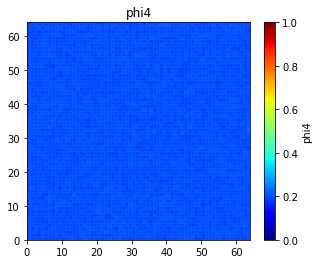

In [7]:
viewer = fp.Matplotlib2DViewer(vars=phi[-1],datamin = 0,datamax =  1.0)

# Define coefficient matrices

In [8]:
chi = np.ones((N,N))*N;
sigma = 0;
b = 5.5;
for i in range(N):
    chi[i,i]=  0.0
    for j in range(i+1,N):
        if i is not (N-1) and j is not (N-1):
            chi[i,j]= np.random.randn(1)*sigma +b;
            chi[j,i] =chi[i,j];
        if i is (N-1) or j is  (N-1):
            chi[i,j]= np.random.randn(1)*sigma +b;
            chi[j,i] =chi[i,j];

np.linalg.eigvals(chi) - N

array([-10.5,  17. , -10.5, -10.5, -10.5])

In [9]:
chi

array([[0. , 5.5, 5.5, 5.5, 5.5],
       [5.5, 0. , 5.5, 5.5, 5.5],
       [5.5, 5.5, 0. , 5.5, 5.5],
       [5.5, 5.5, 5.5, 0. , 5.5],
       [5.5, 5.5, 5.5, 5.5, 0. ]])

In [10]:
coefficient_time = np.identity(N)


In [11]:
def get_diffusion_coefficients(phi,i,j,flag=True):
    if flag:
        z = phi[i]*(np.float(i==j) - phi[j]);
    else:
        z = phi[i]*(np.float(i==j));        
    return (z)

In [12]:
# def get_chemical_potential(phi,i):
#     return ( 1 + np.log(phi[i]) + 

In [13]:
def get_jacobian_coefficient(phi,i,j):
    return (np.float(i==j)/(phi[i]) +(1-np.float(i==j))*chi[i,j])

In [14]:
coefficient_diffusion = get_diffusion_coefficients(phi,0,1)
coefficient_diffusion.value

array([-0.03929138, -0.04044217, -0.04103082, ..., -0.0401347 ,
       -0.03966776, -0.0394745 ])

In [15]:
coefficient_j = get_jacobian_coefficient(phi,0,1)
coefficient_j.value

array([5.5, 5.5, 5.5, ..., 5.5, 5.5, 5.5])

In [16]:
kon = 0.0;
koff = kon*N;

In [17]:
lambda_surf = 5e-1;
kappa  = lambda_surf**2*b;
print(kappa)

1.375


In [18]:
eqn = [];
for i in range(N-1):
    tempeqn = fp.TransientTerm(coeff=1.0,var=phi[i])
    for j in range(N):
        for k in range(N):
            tempeqn = tempeqn - fp.DiffusionTerm(coeff=get_diffusion_coefficients(phi,i,j)*get_jacobian_coefficient(phi,k,j),var=phi[k])

        tempeqn = tempeqn + fp.DiffusionTerm(coeff=(get_diffusion_coefficients(phi,i,j),kappa),var=phi[j])
    
    
    tempeqn = tempeqn - fp.DiffusionTerm(coeff=(get_diffusion_coefficients(phi,i,i),0.5*kappa),var=phi[i])
    tempeqn = tempeqn + fp.DiffusionTerm(coeff=(get_diffusion_coefficients(phi,i,i),0.5*kappa),var=phi[i].old)

    
    tempeqn = tempeqn - kon + koff*phi[i]

    eqn.append(tempeqn)
    
tempeqn = fp.TransientTerm(coeff=1.0,var=phi[-1])
for i in range(N-1):
    tempeqn = tempeqn + fp.TransientTerm(coeff=1.0,var=phi[i])
eqn.append(tempeqn)

In [19]:
eqn[0]

(((((((((((((((((((((((((((((((((TransientTerm(coeff=1.0, var=phi0) + DiffusionTerm(coeff=[-(((phi0 * (1.0 - phi0)) * ((1.0 / phi0) + 0.0)))], var=phi0)) + DiffusionTerm(coeff=[-(((phi0 * (1.0 - phi0)) * ((0.0 / phi1) + 5.5)))], var=phi1)) + DiffusionTerm(coeff=[-(((phi0 * (1.0 - phi0)) * ((0.0 / phi2) + 5.5)))], var=phi2)) + DiffusionTerm(coeff=[-(((phi0 * (1.0 - phi0)) * ((0.0 / phi3) + 5.5)))], var=phi3)) + DiffusionTerm(coeff=[-(((phi0 * (1.0 - phi0)) * ((0.0 / phi4) + 5.5)))], var=phi4)) + DiffusionTerm(coeff=((phi0 * (1.0 - phi0)), 1.375), var=phi0)) + DiffusionTerm(coeff=[-(((phi0 * (0.0 - phi1)) * ((0.0 / phi0) + 5.5)))], var=phi0)) + DiffusionTerm(coeff=[-(((phi0 * (0.0 - phi1)) * ((1.0 / phi1) + 0.0)))], var=phi1)) + DiffusionTerm(coeff=[-(((phi0 * (0.0 - phi1)) * ((0.0 / phi2) + 5.5)))], var=phi2)) + DiffusionTerm(coeff=[-(((phi0 * (0.0 - phi1)) * ((0.0 / phi3) + 5.5)))], var=phi3)) + DiffusionTerm(coeff=[-(((phi0 * (0.0 - phi1)) * ((0.0 / phi4) + 5.5)))], var=phi4)) + Diffu

In [20]:
colors = ["Blues","Greens","Reds","Purples","Oranges"]

In [21]:
eqn_final = eqn[0] & eqn[1] & eqn[2] & eqn[3] & eqn[4]

In [22]:
output_folder = 'simulation_data/20201208/'
sim_name = 'test_2d/N_' + str(N) + '/'
fin_folder = output_folder + sim_name + str(np.random.randint(100000)) + '/';
print(fin_folder)
os.makedirs(fin_folder)
os.makedirs(fin_folder + 'Images/')
os.makedirs(fin_folder + 'Mesh/')

with open(fin_folder+ "/stats.txt", 'w+') as stats:
    titles = ["step", "dt"];
    for i in range(N):
        titles.append('phi' + str(i) + '_max')
        titles.append('phi' + str(i) + '_min')
    
    titles.append('max_res')
    titles.append('min_res')

    titles.append('t_sim')
    stats.write("\t".join(titles) + "\n")


simulation_data/20201208/test_2d/N_5/42595/


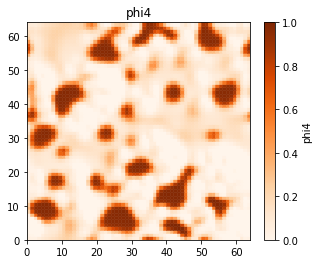

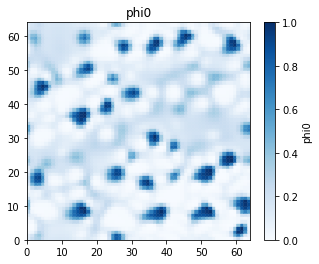

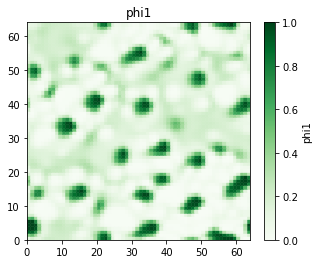

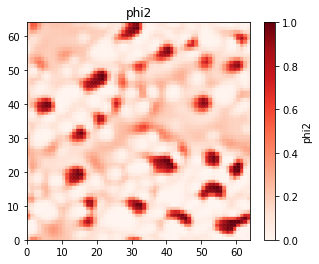

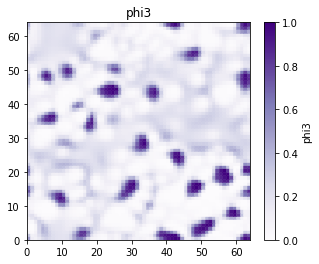

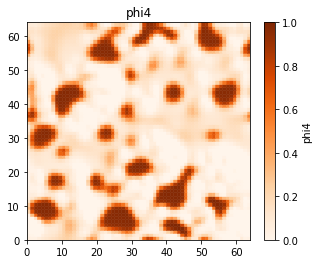

Steps,Time(s),dt,Max_error,Min_error
(17500, '21677.87', 0.025, 2.32996170462501, 2.32996170462501)


/home/krishna/anaconda3/envs/fipy2/lib/python2.7/site-packages/ipykernel_launcher.py:14: MaximumIterationWarning: Iterations: 1001. Relative error: 9.82896e-07
  
/home/krishna/anaconda3/envs/fipy2/lib/python2.7/site-packages/ipykernel_launcher.py:14: MaximumIterationWarning: Iterations: 1001. Relative error: 2.14248e-06
  
/home/krishna/anaconda3/envs/fipy2/lib/python2.7/site-packages/ipykernel_launcher.py:14: MaximumIterationWarning: Iterations: 1001. Relative error: 0.0176825
  
/home/krishna/anaconda3/envs/fipy2/lib/python2.7/site-packages/ipykernel_launcher.py:14: StagnatedSolverWarning: The solver stagnated. Iterations: 1. Relative error: nan
  


Simulation crashed!!


In [23]:
start = timeit.default_timer()
dt = 1e-6;
dt_max = 0.1*lambda_surf**2;
steps = 100000;
for i in range(N):
    phi[i].updateOld()
t = 0;
while (t<steps):

    res = []
    for q in range(1):
        l=0;    
        for i in range(N):
            p = eqn[i].sweep(dt=dt)
            l = max(l,abs(p))
#         print(l)
        res.append(l)
    if max(res) > 1e-4:
        dt *= 1.1
        dt = min(dt, dt_max)
        for i in range(N):
            phi[i].updateOld()
    else:
        dt *= 0.8
        for i in range(N):
            phi[i][:] = phi[i].old
    
    if t%500 == 0:

        st = [];
        st.append(t);
        st.append(dt)
        for i in range(N):
            st.append((max(phi[i].value)))
            st.append((min(phi[i].value)))
        st.append(max(res))
        st.append(min(res))
        st.append(str(round((timeit.default_timer()-start),2)))

        fp.TSVViewer(vars=phi).plot(filename=fin_folder +"Mesh/mesh_{step}.txt".format(step=t))    
        with open(fin_folder+ "/stats.txt", 'a') as stats:
            stats.write("\t".join([str(it) for it in st]) + "\n")


        for i in range(N):
            print('phi' + str(i) + '  = ' + str(max(phi[i].value)))
            fp.MatplotlibViewer(vars=phi[i],datamin = 0,datamax =1.0,cmap=plt.get_cmap(colors[i])).plot(filename=fin_folder + 'Images/phi' + str(i)+ "_" + str(t) + ".png")
        plt.show()
        print('Steps,Time(s),dt,Max_error,Min_error')
        print(t,str(round((timeit.default_timer()-start),2)),dt,max(res),min(res))
        
    if np.isnan(min(phi[0])):
        t = steps+1;
        print('Simulation crashed!!')
    else:
        t+=1;
#     eqn_final.solve(dt=1.e-2)

In [24]:
np.isnan(min(phi[0]))

True

P = np.ones((N,N))*N;
G = (np.ones((N,N))/N)*(1-np.ones((N,N))/N);
sigma = 3;
b = 1;
for i in range(N):
    for j in range(i+1,N):
        if i is not (N-1) and j is not (N-1):
            P[i,j]= np.random.randn(1)*sigma +b;
            P[j,i] =P[i,j];
        if i is (N-1) or j is  (N-1):
            P[i,j]= np.random.randn(1)*sigma +b;
            P[j,i] =P[i,j];
        G[i,j]= -1.0/(N**2);
        G[j,i] =-1.0/(N**2);
        
P

np.linalg.eigvals(np.matmul(G,P)),np.linalg.eigvals(P), np.linalg.eigvals(G)

# np.matmul(G,P)